In [60]:
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from scipy.stats import linregress
from sklearn import datasets
from pprint import pprint
from sb_history import geoapify_key

import warnings
warnings.filterwarnings("ignore")


In [61]:
# Save config information
url = "https://data.opendatasoft.com/api/explore/v2.1/catalog/datasets/super-bowl@public/records?limit=54"
geo_url = "https://api.geoapify.com/v1/geocode/search"

In [62]:
super_bowl_url = requests.get(url)
super_bowl_data = super_bowl_url.json()
#pprint(super_bowl_data)


In [63]:
results = super_bowl_data.get("results", [])
super_bowl_data_df = pd.DataFrame(results)


In [64]:
stadium_city = {"Los Angeles, California", "Miami, Florida", "New Orleans, Louisiana", "Houston, Texas", "Pasadena, California", "Pontiac, Michigan",
                "Tampa, Florida", "Palo Alto, California", "San Diego, California", "Miami Gardens, Florida", "Minneapolis, Minnesota", "Atlanta, Georgia",
                "Tempe, Arizona", "Jacksonville, Florida", "Detroit, Michigan", "Glendale, Arizona", "Arlington, Texas", "Indianapolis, Indiana", 
                "East Rutherford, New Jersey", "Santa Clara, California"}
columns = ['City', 'Latitude', 'Longitude']
locations_df = pd.DataFrame(columns=columns)
for city in stadium_city:
    
    params = { 
    "text": city,
    "apiKey" : geoapify_key
    }

    stadium_response = requests.get(geo_url, params=params).json()
   
    lat = stadium_response["features"][0]["properties"]["lat"]
    lon = stadium_response["features"][0]["properties"]["lon"]

    sb_location_data = {
        'City': city,
        'Latitude': lat,
        'Longitude': lon
    }
    
    #print(f"{city}: {lat}, {lon}")
    locations_df = pd.concat([locations_df, pd.DataFrame([sb_location_data])], ignore_index=True)
locations_df[['city', 'state']] = locations_df['City'].str.split(', ', 1, expand=True)
locations_df.drop(columns=['City'], inplace=True)
locations_df


,Latitude,Longitude,city,state
0,42.638922,-83.291047,Pontiac,Michigan
1,32.735582,-97.107119,Arlington,Texas
2,30.332184,-81.655651,Jacksonville,Florida
3,29.975998,-90.078213,New Orleans,Louisiana
4,44.977300,-93.265469,Minneapolis,Minnesota
5,25.774173,-80.193620,Miami,Florida
6,25.979814,-80.202547,Miami Gardens,Florida
7,40.833989,-74.097087,East Rutherford,New Jersey
8,34.147651,-118.144155,Pasadena,California
9,34.053691,-118.242766,Los Angeles,California


In [65]:
super_bowl_history_df = pd.merge(super_bowl_data_df, locations_df, how="left", on=["city","state"])
super_bowl_history_df['date'] = pd.to_datetime(super_bowl_history_df['date'])
super_bowl_history_df.sort_values(by='date', ascending=True, inplace=True)
super_bowl_history_df.reset_index(drop=True, inplace=True)
super_bowl_history_df.head()

,date,sb,attendance,winner,qb_winner,coach_winner,winning_pts,loser,qb_loser,coach_loser,...,umpire,head_linesman,line_judge,field_judge,back_judge,side_judge,geo_shape,geo_point_2d,Latitude,Longitude
0,1967-01-15,I,61946,Green Bay Packers,Bart Starr,Vince Lombardi,35,Kansas City Chiefs,Len Dawson,Hank Stram,...,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -119.640543961, 'lat': 37.2551445335}",34.053691,-118.242766
1,1968-01-14,II,75546,Green Bay Packers,Bart Starr,Vince Lombardi,33,Oakland Raiders,Daryle Lamonica,John Rauch,...,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}",25.774173,-80.193620
2,1969-01-12,III,75389,New York Jets,Joe Namath,Weeb Ewbank,16,Baltimore Colts,"Earl Morrall, Johnny Unitas",Don Shula,...,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}",25.774173,-80.193620
3,1970-01-11,IV,80562,Kansas City Chiefs,"Len Dawson, Mike Livingston",Hank Stram,23,Minnesota Vikings,Joe Kapp,Bud Grant,...,None,None,None,None,None,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -91.9572061819, 'lat': 31.0480777894}",29.975998,-90.078213
4,1971-01-17,V,79204,Baltimore Colts,"Earl Morrall , Johnny Unitas",Don McCafferty,16,Dallas Cowboys,Craig Morton,Tom Landry,...,Paul Trepinski,Ed Marion,Jack Fette,Fritz Graf,Hugh Gamber,None,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -82.5025741003, 'lat': 28.6169283051}",25.774173,-80.193620


In [66]:
drop_columns = ["referee", "umpire", "head_linesman", "line_judge", 
                "field_judge", "back_judge", "side_judge", "qb_winner",
                "coach_winner", "winning_pts", "qb_loser", "coach_loser",
                "losing_pts", "mvp","point_difference","geo_shape", "geo_point_2d"]
super_bowl_history_df.drop(columns=drop_columns, inplace=True)
super_bowl_history_df.head()

,date,sb,attendance,winner,loser,stadium,city,state,Latitude,Longitude
0,1967-01-15,I,61946,Green Bay Packers,Kansas City Chiefs,Memorial Coliseum,Los Angeles,California,34.053691,-118.242766
1,1968-01-14,II,75546,Green Bay Packers,Oakland Raiders,Orange Bowl,Miami,Florida,25.774173,-80.193620
2,1969-01-12,III,75389,New York Jets,Baltimore Colts,Orange Bowl,Miami,Florida,25.774173,-80.193620
3,1970-01-11,IV,80562,Kansas City Chiefs,Minnesota Vikings,Tulane Stadium,New Orleans,Louisiana,29.975998,-90.078213
4,1971-01-17,V,79204,Baltimore Colts,Dallas Cowboys,Orange Bowl,Miami,Florida,25.774173,-80.193620


In [67]:
sb_views = "Resources/Super Bowl Ratings and viewership, all-time.csv"

views_df = pd.read_csv(sb_views)

views_df = views_df.sort_values(by="Year", ascending=True) 
views_df = views_df.drop_duplicates(subset="Year", keep="first")
views_extract = views_df["Overall TV Vwrs"]
views_extract = views_extract[:-3]
views_extract  = views_extract.reset_index(drop=True)
views_extract.head()


0    26750000.0
1    39120000.0
2    41660000.0
3    44270000.0
4    46040000.0
Name: Overall TV Vwrs, dtype: float64

In [68]:
final_df = pd.merge(super_bowl_history_df, views_extract, how="left", left_index=True, right_index=True)
final_df = final_df.rename(columns={"date": "Date", "sb": "Super Bowl", "attendance": "Attendance", 
                        "winner": "Winning Team", "loser": "Losing Team", "stadium": "Stadium", 
                        "city": "City", "state": "State","Overall TV Vwrs": "Average TV Viewership (US)"})

final_df["Average TV Viewership (US)"] = final_df["Average TV Viewership (US)"].astype(int).round(0)
final_df = final_df.reset_index(drop=True)
final_df.head()



,Date,Super Bowl,Attendance,Winning Team,Losing Team,Stadium,City,State,Latitude,Longitude,Average TV Viewership (US)
0,1967-01-15,I,61946,Green Bay Packers,Kansas City Chiefs,Memorial Coliseum,Los Angeles,California,34.053691,-118.242766,26750000
1,1968-01-14,II,75546,Green Bay Packers,Oakland Raiders,Orange Bowl,Miami,Florida,25.774173,-80.193620,39120000
2,1969-01-12,III,75389,New York Jets,Baltimore Colts,Orange Bowl,Miami,Florida,25.774173,-80.193620,41660000
3,1970-01-11,IV,80562,Kansas City Chiefs,Minnesota Vikings,Tulane Stadium,New Orleans,Louisiana,29.975998,-90.078213,44270000
4,1971-01-17,V,79204,Baltimore Colts,Dallas Cowboys,Orange Bowl,Miami,Florida,25.774173,-80.193620,46040000


The r-squared is: 0.8230394157030263


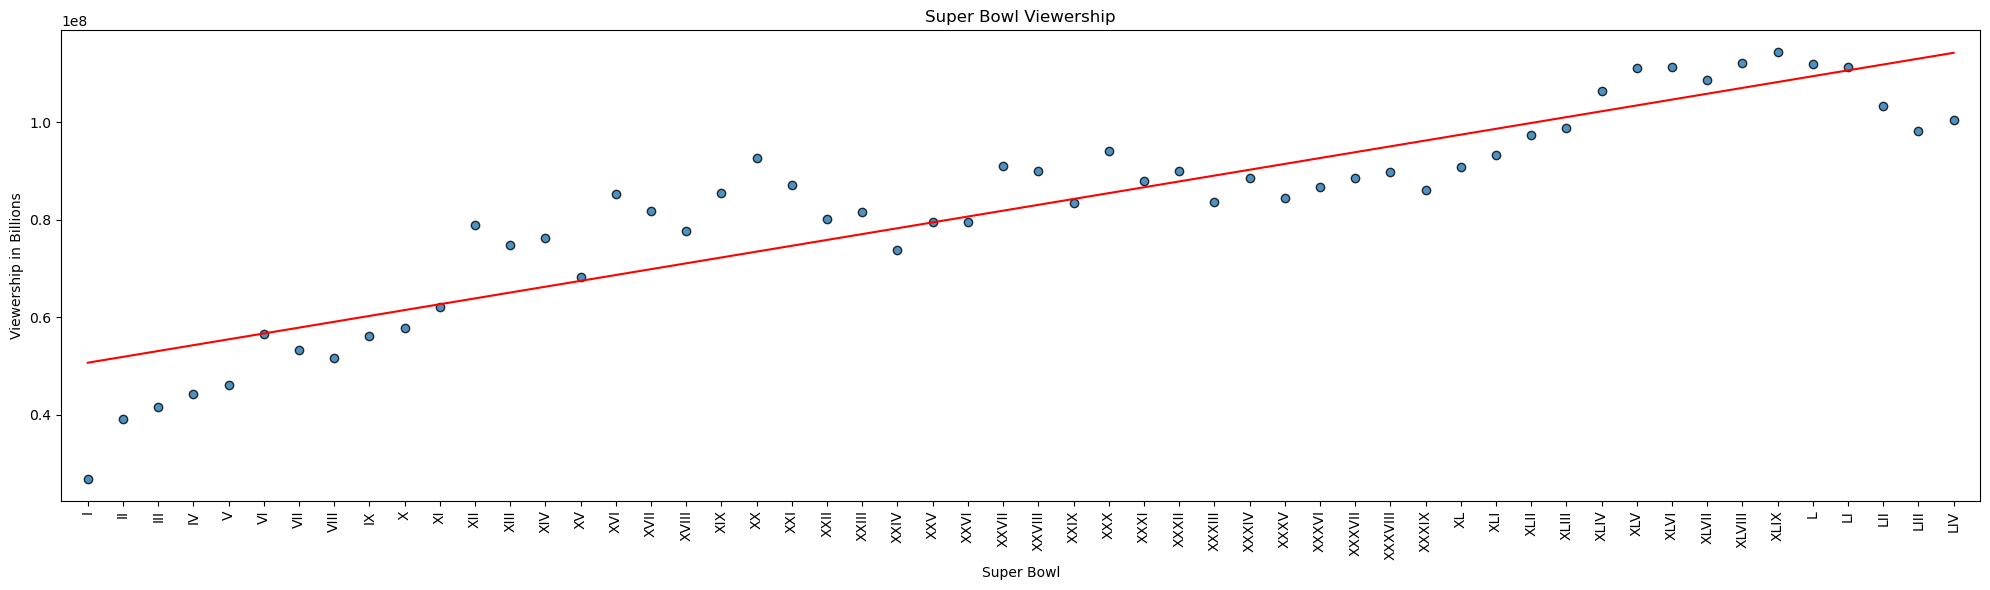

In [69]:

x_values = np.arange(len(final_df))
y_values = final_df["Average TV Viewership (US)"]
x_tick_locations = [value for value in x_values]

plt.figure(figsize=(20,6))

(slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
regress_values = intercept + slope * x_values
line_eq = "y =" + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.plot(x_values, regress_values, "r-")
plt.scatter(x_values, y_values, edgecolor="black", marker="o", alpha=0.8)
plt.annotate(line_eq, (10, 50), color="red")

plt.xticks(x_tick_locations, final_df["Super Bowl"], rotation=90)
plt.xlim(-0.75, len(x_values)-0.25)

plt.title("Super Bowl Viewership")
plt.xlabel("Super Bowl")
plt.ylabel("Viewership in Billions")

print(f"The r-squared is: {r_value**2}")
plt.tight_layout()
plt.savefig("Output/super_bowl_viewership.png")
plt.show()



The r-squared is: 0.10972366452732037


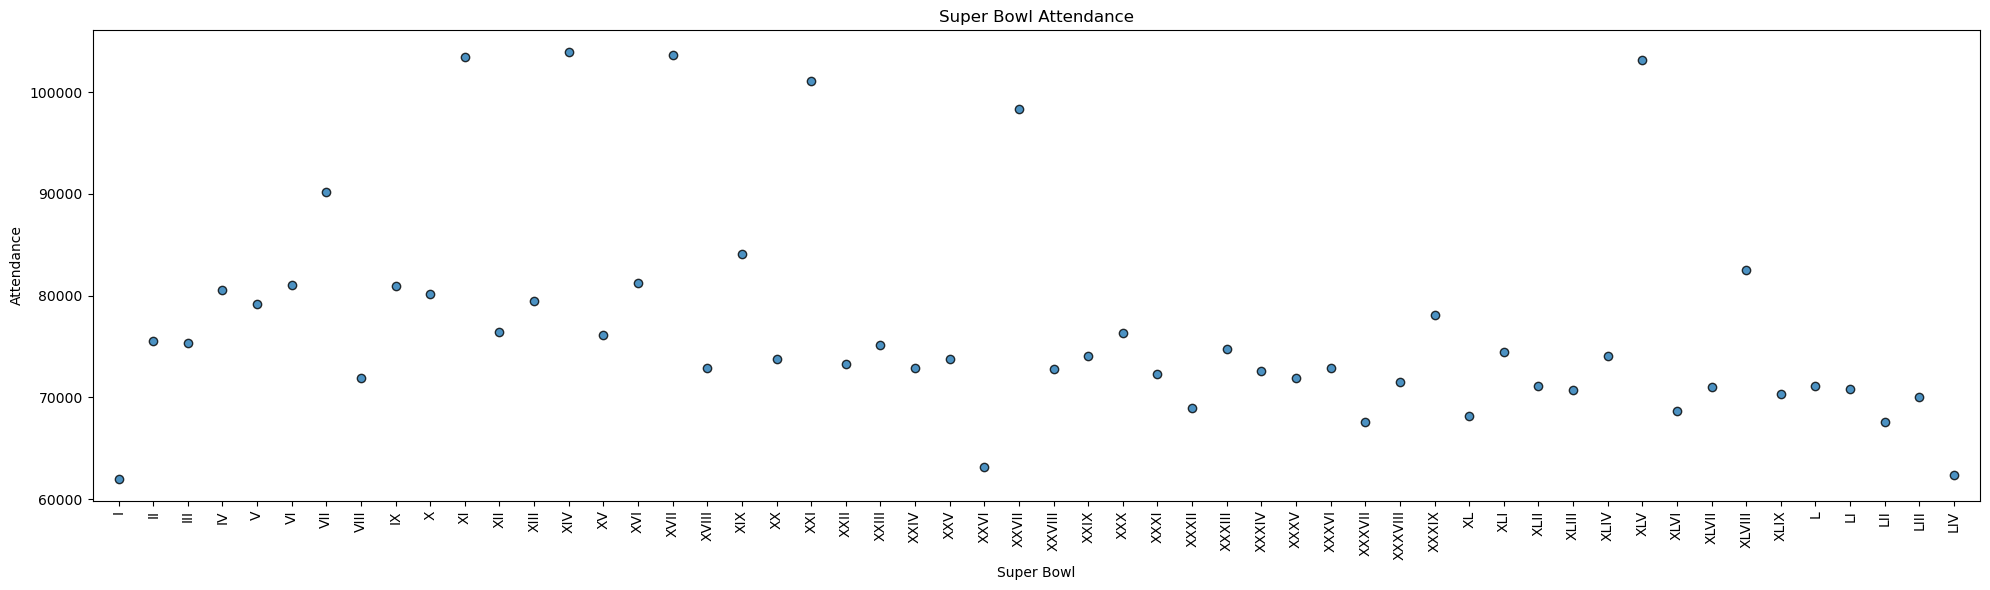

In [72]:
x_values = np.arange(len(final_df))
y_values = final_df["Attendance"]
x_tick_locations = [value for value in x_values]

plt.figure(figsize=(20,6))

(slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
regress_values = intercept + slope * x_values
line_eq = "y =" + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
#plt.plot(x_values, regress_values, "r-")
plt.scatter(x_values, y_values, edgecolor="black", marker="o", alpha=0.8)
#plt.annotate(line_eq, (10, 50), color="red")

plt.xticks(x_tick_locations, final_df["Super Bowl"], rotation=90)
plt.xlim(-0.75, len(x_values)-0.25)

plt.title("Super Bowl Attendance")
plt.xlabel("Super Bowl")
plt.ylabel("Attendance")


print(f"The r-squared is: {r_value**2}")
plt.tight_layout()
plt.savefig("Output/super_bowl_attendance.png")
plt.show()


In [71]:


stadium_locations = pd.DataFrame(final_df)

super_bowl_plot = stadium_locations.hvplot.points(
    
    x="Longitude",
    y="Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Attendance",
    scale = 0.07,
    color = "City",
    hover_cols = ["Super Bowl","City", "State", "Attendance"],
    title = "Super Bowl Attendance"
)

super_bowl_plot



:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City,Attendance,Super Bowl,State)